# Sesssion 12: Final Coding test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Bài Test có nội dung đơn giản, đủ để làm xong trong 1 giờ 30 phút. Bạn nên tự canh thời gian để làm thử.

## Language Model cho kí tự Alphabet và số

Như bạn đã được trải nghiệm, Language Model có công dụng cơ bản nhất là biễu diễn các từ bằng 1 vector số sao cho những từ có ngữ nghĩa tương đồng nhau sẽ có khoảng cách trong không gian vector gần nhau.

Trước khi bắt đầu code, bạn hãy thử suy nghĩ xem kết quả của Language model cho các kí tự Alphabet và số sẽ như thế nào?

**Đọc dữ liệu**

Dữ liệu của chúng ta gồm tiêu đề của 10000 bài báo tiếng Anh được lưu dưới dạng 1 `list`

In [ ]:
import pickle as pkl

with open("/content/drive/MyDrive/Colab Notebooks/ML-intensive/data/problem_1.pkl", "rb") as f:
  data = pkl.load(f)

print(data[0:10])

['aba decides against community broadcasting licence', 'act fire witnesses must be aware of defamation', 'a g calls for infrastructure protection summit', 'air nz staff in aust strike for pay rise', 'air nz strike to affect australian travellers', 'ambitious olsson wins triple jump', 'antic delighted with record breaking barca', 'aussie qualifier stosur wastes four memphis match', 'aust addresses un security council over iraq', 'australia is locked into war timetable opp']


In [ ]:
data

['aba decides against community broadcasting licence',
 'act fire witnesses must be aware of defamation',
 'a g calls for infrastructure protection summit',
 'air nz staff in aust strike for pay rise',
 'air nz strike to affect australian travellers',
 'ambitious olsson wins triple jump',
 'antic delighted with record breaking barca',
 'aussie qualifier stosur wastes four memphis match',
 'aust addresses un security council over iraq',
 'australia is locked into war timetable opp',
 'australia to contribute 10 million in aid to iraq',
 'barca take record as robson celebrates birthday in',
 'bathhouse plans move ahead',
 'big hopes for launceston cycling championship',
 'big plan to boost paroo water supplies',
 'blizzard buries united states in bills',
 'brigadier dismisses reports troops harassed in',
 'british combat troops arriving daily in kuwait',
 'bryant leads lakers to double overtime win',
 'bushfire victims urged to see centrelink',
 'businesses should prepare for terrorist a

**Hướng tiếp cận**

Ta sẽ xây dựng 1 Language Model **rất cơ bản** bằng cách sau:
- Dùng layer Embedding để tạo ra biểu diễn của từng từ trong bộ dữ liệu
- Cập nhật trọng số cho layer Embedding thông qua bài toán **"Dự đoán kí tự tiếp theo với đầu vào là 1 kí tự duy nhất đằng trước"** (bài toán phân loại nhiều nhãn, số lượng nhãn chính là số lượng kí tự unique xuất hiện trong dataset)

Do đó, từ các đoạn văn bản trên, ta cần xây dựng 1 dataset với `x` là 1 kí tự và `y` là kí tự liền kề ngay sau đó.

Ví dụ: câu đầu tiên trong bộ dữ liệu là `aba decides against community broadcasting licence`

Câu này có độ dài là 50 kí tự (tính cả khoảng trắng) → ta sẽ tạo được 49 mẫu dữ liệu để huấn luyện mô hình
```
# ví dụ đoạn "aba decides" sẽ tạo được các cặp x y như sau
x     | y
------|-------
a     | b
b     | a
a     | space
space | d
d     | e
e     | c
c     | i
i     | d
d     | e
e     | s
```

#### TODO 1

Hãy viết code để:
- Tạo ra `x_char` và `y_char` chứa dữ liệu huấn luyện theo mô tả trên (làm trên toàn bộ dữ liệu trong biến `data`)
- Tạo ra `unique_chars` là `list` chứa các kí tự unique trong `data` (tính cả kí tự khoảng trắng), dữ liệu trong list này được `sắp xếp tăng dần`.
- Dựa vào `unique_chars`:
  - Tạo ra `NUM_CHAR` cho biết số lượng kí tự unique trong `data`
  - Tạo ra `char_to_index` và `index_to_char` là 2 `dictionary` dùng để mapping từng kí tự với index của chúng và ngược lại

In [ ]:
len(data)

10000

In [ ]:
x_char = []
y_char = []
unique_chars = []
char_to_index = {}
index_to_char = {}
NUM_CHAR = 0



In [ ]:
def prepare():
  x_char = []
  y_char = []
  unique_chars = []
  NUM_CHAR = 0
  char_to_index = {}
  index_to_char = {}

  for word in data:
    for char in word:
      if char not in unique_chars:
        unique_chars.append(char)

    for char in word[:-1]:
      x_char.append("space" if char == " " else char)

    for char in word[1:]:
      y_char.append("space" if char == " " else char)

  unique_chars = [char if char != " " else "space" for char in unique_chars]

  # sorting
  unique_chars.sort()
  NUM_CHAR = len(unique_chars)

  # mapping
  for index, char in enumerate(unique_chars):
    char_to_index[char] = index
    index_to_char[index] = char

  return x_char, y_char, unique_chars, NUM_CHAR, char_to_index, index_to_char

x_char, y_char, unique_chars, NUM_CHAR, char_to_index, index_to_char = prepare()

len(x_char), len(y_char), len(unique_chars), len(char_to_index), len(index_to_char), NUM_CHAR

(386880, 386880, 37, 37, 37, 37)

Sau khi bạn đã tạo đủ các biến trên, đoạn code bên dưới sẽ tạo ra `x` `y` là dữ liệu huấn luyện mô hình

In [ ]:
x = []
y = []
for char_x, char_y in zip(x_char, y_char):
  x.append(char_to_index[char_x])
  y.append(char_to_index[char_y])

len(x), len(y)

(386880, 386880)

#### TODO 2

Bạn hãy dùng Tensorflow để xây dựng mô hình như sau, mô hình gồm 2 layer
- `Input`
- `Embedding` với
  - Số dòng bằng số lượng kí tự unique
  - Mỗi kí tự được biểu diễn bằng 1 vector có 2 con số
  - Đặt tên cho layer này là `"embedding"`
    - `model.add(Embedding(..., name="embedding"))`

Chỉ cần tạo mô hình thôi, không cần compile và fit



In [ ]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding
import numpy as np

clear_session()
set_seed(42)
np.random.seed(42)

EMB_FEATURES = 2

model = Sequential([
  Input(shape=(1,)),
  Embedding(NUM_CHAR, 2, name="embedding")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 2)              74        
                                                                 
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


Do layer cuối của mô hình là `Embedding`, khi ta gọi hàm `predict` và truyền vào toàn bộ các kí tự unique, ta sẽ nhận được biểu diễn của chúng (bạn cần implement mô hình đúng để các đoạn code bên dưới chạy được)

In [ ]:
character_embeddings = model.predict(list(index_to_char.keys()))
print(character_embeddings.shape) # chú ý kết quả in ra

2/2 [==============================] - 0s 7ms/step
(37, 1, 2)


Vẽ thử không gian vector của các kí tự

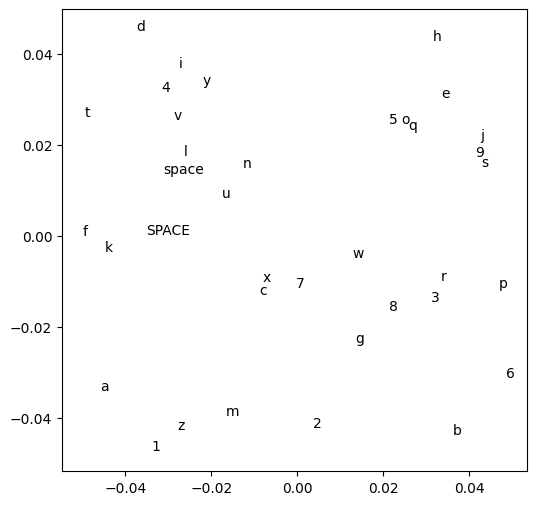

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for index, vector in enumerate(character_embeddings):
  plt.scatter(vector[0, 0], vector[0, 1], alpha=0)
  if index != 0:
    plt.text(vector[0, 0], vector[0, 1], index_to_char[index])
  else:
    plt.text(vector[0, 0], vector[0, 1], "SPACE")
plt.show()

Ta thấy khi chưa huấn luyện các kí tự được phân bổ rất là lộn xộn trong không gian

### Huấn luyện

Để huấn luyện mô hình, ta cần One Hot Encoding biến `y`.

Kết quả One Hot là `y_encode` có shape `(num_sample, 37)`

Do layer Embedding sẽ trả về kết quả có shape là `(batch_size, 1, 2)`, ta sẽ biến đổi kết quả One Hot để có shape tương tự (nếu bạn không hiểu chỗ này thì cứ thử xóa phần `expand_dims` và làm TODO 3 bên dưới sẽ thấy báo lỗi)

In [ ]:
x = np.array(x_char)

# one hot và biến đổi shape để có thêm số 1 ở giữa
y_encode = tf.keras.utils.to_categorical(y, num_classes=NUM_CHAR)
y_encode = np.expand_dims(y_encode, axis=1)
print(y_encode.shape)

(386880, 1, 37)


#### TODO 3

- Ghép thêm `1 layer Dense` vào mô hình, layer này dùng để dự đoán
- Huấn luyện mô hình đơn giản trên trong 5 epochs với `model.compile(..., optimizer="adam", metrics=["accuracy"]`)

In [ ]:
# YOUR SOLUTION
model = Sequential([
  Input(shape=(1,)),
  Embedding(NUM_CHAR, 2, name="embedding"),
  Dense(37, activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x, y_encode, epochs=5)

Epoch 1/5
12090/12090 [==============================] - 21s 2ms/step - loss: 2.7701 - accuracy: 0.1777
Epoch 2/5
12090/12090 [==============================] - 21s 2ms/step - loss: 2.6797 - accuracy: 0.1917
Epoch 3/5
12090/12090 [==============================] - 21s 2ms/step - loss: 2.6777 - accuracy: 0.1909
Epoch 4/5
12090/12090 [==============================] - 22s 2ms/step - loss: 2.6771 - accuracy: 0.1904
Epoch 5/5
12090/12090 [==============================] - 20s 2ms/step - loss: 2.6766 - accuracy: 0.1907


Sau khi huấn luyện xong, ta sẽ bỏ đi layer `Dense` ở cuối để có được Language Model (đưa vào 1 kí tự trả ra vector biểu diễn kí tự đó)

In [ ]:
from tensorflow.keras.models import Model

language_model = Model(
  inputs=model.input,
  outputs=model.get_layer("embedding").output
)

2/2 [==============================] - 0s 6ms/step


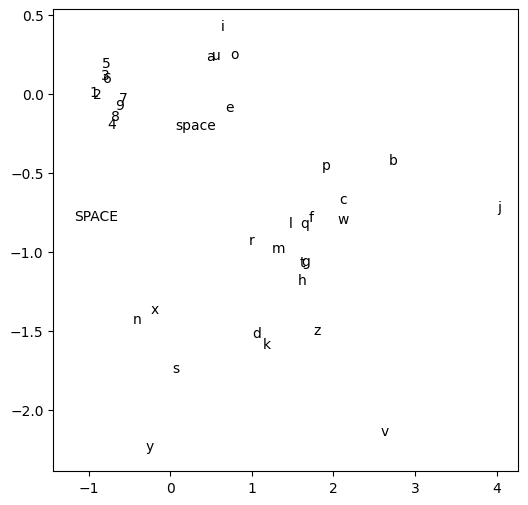

In [ ]:
char_embeddings = language_model.predict(list(index_to_char.keys()))

plt.figure(figsize=(6, 6))
for index, vector in enumerate(char_embeddings):
  plt.scatter(vector[0, 0], vector[0, 1], alpha=0)
  if index != 0:
    plt.text(vector[0, 0], vector[0, 1], index_to_char[index])
  else:
    plt.text(vector[0, 0], vector[0, 1], "SPACE")
plt.show()

Quan sát vị trí của các kí tự trong không gian vector, bạn sẽ thấy được:
- Cụm `e u o a i` nằm chung
- Cụm các kí tự alphabet còn lại
- Cụm các số
- Kí tự SPACE

## Optical Character Recognition

Ở phần này chúng ta thực hành kết hợp mô hình CNN và RNN để giải quyết bài toán nhận dạng chữ quang học.

Mô hình đã được train sẵn, các bạn chỉ cần **viết code để tạo kiến trúc cho mô hình theo hướng dẫn**, sau đó load file trọng số vào mô hình.




### Chuẩn bị dữ liệu

Ta có biến ``char_list`` chứa toàn bộ các kí tự Alphabet (a-z, A-Z) và số (0-9)

In [ ]:
import string

char_list = string.ascii_letters+string.digits
print(char_list)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789


**Đọc dữ liệu từ file pickle**

Sửa đường dẫn lại đến 2 file `img.pkl` và `label.pkl` trong thư mục `ocr_data`



In [ ]:
import pickle

def load_pickle_data(path):
  f = open(path, 'rb')
  data = pickle.load(f)
  f.close()
  return data

IMG_PATH = '/content/drive/MyDrive/Colab Notebooks/ML-intensive/data/ocr_data/img.pkl'
LABEL_PATH = '/content/drive/MyDrive/Colab Notebooks/ML-intensive/data/ocr_data/label.pkl'

img = load_pickle_data(IMG_PATH)
label = load_pickle_data(LABEL_PATH)

**Xem thử dữ liệu**

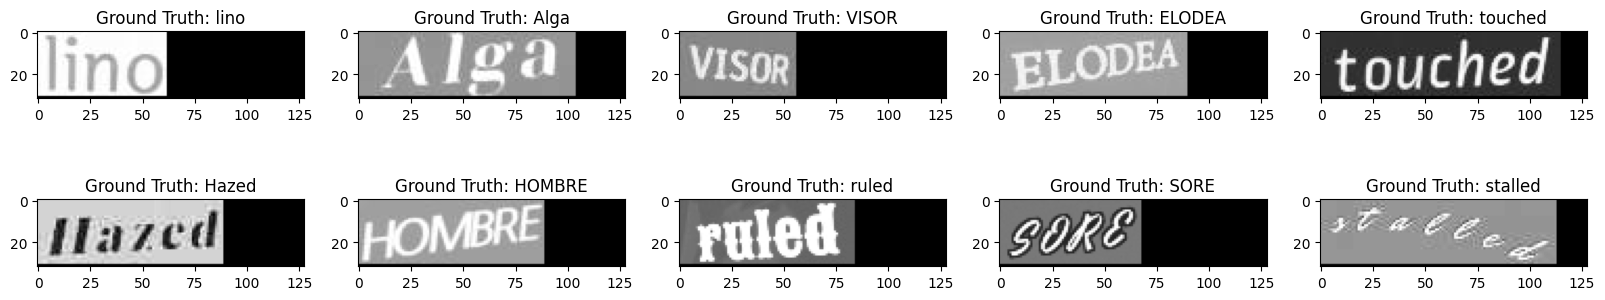

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,4))
for i in range(10):
  target = np.random.randint(0, len(img))
  plt.subplot(2,5, i+1)
  imgplot = plt.imshow(img[target].reshape(32, 128),cmap='binary')
  title = 'Ground Truth: '
  for j in label[target]:
    title += char_list[j]
  plt.title(title)
plt.show()

Ta thực hiện convert img từ list sang numpy array

In [ ]:
img = np.array(img)
print('Dataset Shape =', img.shape)

Dataset Shape = (1371, 32, 128, 1)


### Tạo kiến trúc

#### TODO 4
**Làm đúng bước này thì các bước bên dưới MỚI chạy được**

- Khi chạy ô code bên dưới sẽ hiện ra hướng dẫn tạo kiến trúc mô hình
- Trong đó các hình chữ nhật có màu tượng trưng cho 1 layer trong mô hình.
- Ấn vào hình chữ nhật để **hiển thị / tắt** các thông số của layer đó.
  - Dựa vào **tên layer và các thông số gợi ý để tự tính ra các thông số ? màu đỏ**
  - 2 layer màu tím (LSTM) bạn không cần quan tâm thông số `dropout=0.2`




In [ ]:
from IPython.display import HTML
HTML('<iframe width="100%" height="250" src="https://final-exam-litahung.vercel.app/ml" allowfullscreen></iframe>')

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Lambda, Bidirectional, LSTM
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

model = Sequential()

# YOUR CODE
model = Sequential([
    Input(shape=(32,128,1)),
    Conv2D(64, 3, padding="same", activation="relu", name="Convolution_1"),
    MaxPool2D(pool_size=2, name="Max_Pooling_1"),
    Conv2D(128, 3, padding="same", activation="relu", name="Convolution_2"),
    MaxPool2D(pool_size=2, name="Max_Pooling_2"),
    Conv2D(256, 3, padding="same", activation="relu", name="Convolution_3"),
    Conv2D(256, 3, padding="same", activation="relu", name="Convolution_4"),
    MaxPool2D(pool_size=(2, 1), name="Max_Pooling_3"),
    Conv2D(512, 3, padding="same", activation="relu", name="Convolution_5"),
    BatchNormalization(),
    Conv2D(512, 3, padding="same", activation="relu", name="Convolution_6"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,1), name="Max_Pooling_4"),
    Conv2D(512, 2, padding="valid", activation="relu", name="Convolution_7"),
    Lambda(lambda x: K .squeeze(x,1)),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)),
    Dense(63, activation="softmax")
])

model.summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolution_1 (Conv2D)      (None, 32, 128, 64)       640       
                                                                 
 Max_Pooling_1 (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 Convolution_2 (Conv2D)      (None, 16, 64, 128)       73856     
                                                                 
 Max_Pooling_2 (MaxPooling2D  (None, 8, 32, 128)       0         
 )                                                               
                                                                 
 Convolution_3 (Conv2D)      (None, 8, 32, 256)        295168    
                                                                 
 Convolution_4 (Conv2D)      (None, 8, 32, 256)      


Thay đổi đường dẫn đến nơi đặt bộ trọng số trong Drive của mình (file `ocr_weights.hdf5`)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/ML-intensive/data/ocr_weights.hdf5')

### Inference

Nếu các bạn tạo kiến trúc đúng thì có thể chạy các ô code bên dưới

In [ ]:
prediction = model.predict(img)
result = K.ctc_decode(prediction,
                      input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                      greedy=True)[0][0]
result = K.get_value(result)

43/43 [==============================] - 45s 1s/step


Biến ``result`` chứa kết quả dự đoán của mô hình (index của các ký tự), tuy nhiên ta không quan tâm đến những giá trị bằng ``-1``

In [ ]:
print('Result shape:', result.shape)
print('1st item of result:', result[0])

Result shape: (1371, 31)
1st item of result: [35 14 18 20  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1]


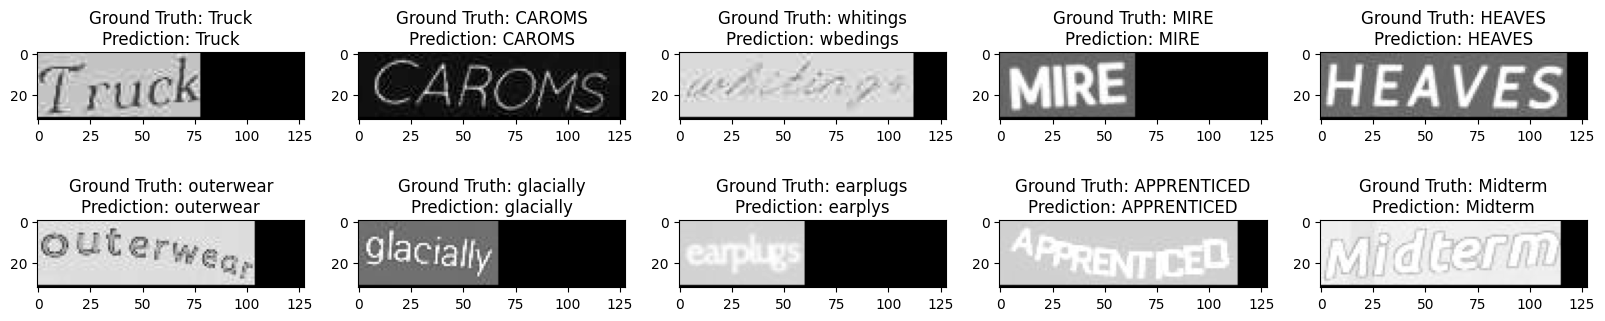

In [ ]:
plt.figure(figsize=(20,4))
for i in range(10):
  target = np.random.randint(0, len(img))
  plt.subplot(2,5, i+1)
  imgplot = plt.imshow(img[target].reshape(32, 128),cmap='binary')
  title = 'Ground Truth: '
  for j in label[target]:
    title += char_list[j]
  title = title + '\nPrediction: '
  for k in result[target]:
    if k == -1:
      continue
    title += char_list[k]
  plt.title(title)
plt.show()